https://github.com/0liu/ISLR/blob/master/Chapter%207%20Moving%20Beyond%20Linearity.ipynb

### data

In [87]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import warnings
import numpy as np
import scipy as sp
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
# 회귀분석 전처리를 위한 패키지 patsy
from patsy import dmatrix

from sklearn.preprocessing import PolynomialFeatures

# from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use("ggplot")

In [0]:
wage = pd.read_csv("/content/drive/My Drive/ISLR/data/Wage.csv")
wage.set_index(wage.columns[0], inplace = True)
wage.index.name = None

In [142]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   region      3000 non-null   object 
 6   jobclass    3000 non-null   object 
 7   health      3000 non-null   object 
 8   health_ins  3000 non-null   object 
 9   logwage     3000 non-null   float64
 10  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 281.2+ KB


orthogonal_poly ref: http://davmre.github.io/python/2013/12/15/orthogonal_poly

In [0]:
def ortho_poly_fit(x, degree = 1):
  n = degree + 1
  x = np.asarray(x).flatten()
  
  if(degree >= len(np.unique(x))):
    stop("'degree' must be less than number of unique points")
  
  xbar = np.mean(x)
  x = x - xbar
  X = np.fliplr(np.vander(x, n))
  q, r = np.linalg.qr(X)

  z = np.diag(np.diag(r))
  raw = np.dot(q, z)

  norm2 = np.sum(raw**2, axis = 0)
  alpha = (np.sum((raw**2)*np.reshape(x, (-1, 1)), axis = 0)/norm2 + xbar)[:degree]
  Z = raw / np.sqrt(norm2)
  return Z, norm2, alpha

### **Polynomial Regression and Step Functions**

#### Polynomial Regression

> #### Anova on degree from 1 to 5

In [0]:
X1 = PolynomialFeatures(1).fit_transform(wage[["age"]])
X2 = PolynomialFeatures().fit_transform(wage[["age"]])
X3 = PolynomialFeatures(3).fit_transform(wage[["age"]])
X4 = PolynomialFeatures(4).fit_transform(wage[["age"]])
X5 = PolynomialFeatures(5).fit_transform(wage[["age"]])

poly1 = sm.GLS(wage.wage, X1).fit()
poly2 = sm.GLS(wage.wage, X2).fit()
poly3 = sm.GLS(wage.wage, X3).fit()
poly4 = sm.GLS(wage.wage, X4).fit()
poly5 = sm.GLS(wage.wage, X5).fit()

In [145]:
anova_lm(poly1, poly2, poly3, poly4, poly5)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


p-value가 작은 quartic과 cubic polynomial model이 적합해 보인다.

> #### degree 4

> ##### 1. on orthogonal(ization)

In [0]:
X4_ortho = ortho_poly_fit(wage[["age"]], 4)[0]
X4_ortho[:, 0] = 1

In [147]:
poly4_ortho = sm.GLS(wage["wage"], X4_ortho).fit()
poly4_ortho.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           2.77e-57
Time:                        12:44:53   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.7036      0.729    153.283      0.000     110.275     113.132
x1           447.0679     39.915     11.201      0.000     368.805     525.331
x2          -478.3158     39.915    -11.983      0.000    -556.579    -400.053
x3           125.5217     39.915      3.145      0.002      47.259     203.785
x4           -77.9112     39.915     -1.952      0.051    -156.174       0.352
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                         54.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

와 근데 coef가 형태도 다르고, coef도 다른데 std err가 다 같으니까 진짜 이상하다.

데이터를 직교하게 했으니 cov에 영향을 다 똑같이 받아서 그런가?

> ##### 2. on raw (without orthogonalization)

In [148]:
poly4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           2.77e-57
Time:                        12:44:53   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.002    -301.879     -66.430
x1            21.2455      5.887      3.609      0.000       9.703      32.788
x2            -0.5639      0.206     -2.736      0.006      -0.968      -0.160
x3             0.0068      0.003      2.221      0.026       0.001       0.013
x4         -3.204e-05   1.64e-05     -1.952      0.051   -6.42e-05    1.45e-07
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     5.67e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

아니, 같은 변수라 다중공선성 의심은 안 해봤네.

모델 함수에 차수가 다른 같은 변수라고 얘기를 안 해서 다중공선성 유의라고 나오는 게 정상이긴 한데

> ##### 3. 됐고 그래서 plot이 어떻게 생겼다고?

In [0]:
age_grid = np.arange(wage.age.min(), wage.age.max()).reshape(-1, 1)
X_test = PolynomialFeatures(4).fit_transform(age_grid)
y_pred = poly4.predict(X_test)

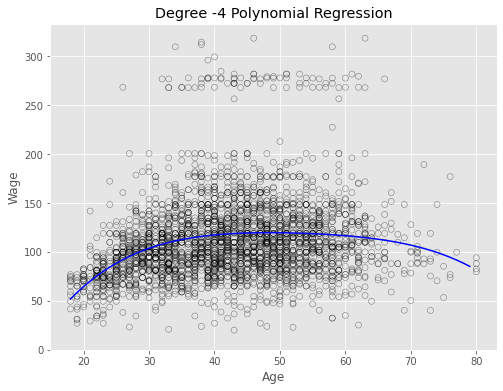

In [150]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(wage.age, wage.wage, facecolor = "None", edgecolor = 'k', alpha = 0.5)
plt.plot(age_grid, y_pred, color = 'b')

ax.set_ylim(ymin = 0)
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title("Degree -4 Polynomial Regression")
plt.show()

> #### degree 5 on orthogonal

In [0]:
X5_ortho = ortho_poly_fit(wage[["age"]], 5)[0]
X5_ortho[:, 0] = 1

In [152]:
poly5_ortho = sm.GLS(wage.wage, X5_ortho).fit()
poly5_ortho.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.087
Model:                            GLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     56.71
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           1.67e-56
Time:                        12:44:53   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2994   BIC:                         3.068e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.7036      0.729    153.278      0.000     110.275     113.133
x1           447.0679     39.916     11.200      0.000     368.802     525.334
x2          -478.3158     39.916    -11.983      0.000    -556.582    -400.050
x3           125.5217     39.916      3.145      0.002      47.256     203.787
x4           -77.9112     39.916     -1.952      0.051    -156.177       0.355
x5           -35.8129     39.916     -0.897      0.370    -114.079      42.453
==============================================================================
Omnibus:                     1094.840   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4940.229
Skew:                           1.718   Prob(JB):                         0.00
Kurtosis:                       8.265   Cond. No.                         54.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

아.. t-value의 제곱이 anova_lm에서 구한 f-value랑 같다고. 뭔 소릴 하나 했네.

> #### Classification: wage > $150,000 per year?

In [153]:
y_clf = (wage.wage > 250).map({False: 0, True: 1})
logreg = sm.GLM(y_clf, X4, family = sm.families.Binomial()).fit()
print(logreg.summary())
# 이건 그냥 summary로는 알아보기가 너무 힘들었음.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Wed, 10 Jun 2020   Deviance:                       701.22
Time:                        12:44:53   Pearson chi2:                 3.70e+03
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.0

In [0]:
y_pred_clf = logreg.predict(X_test)

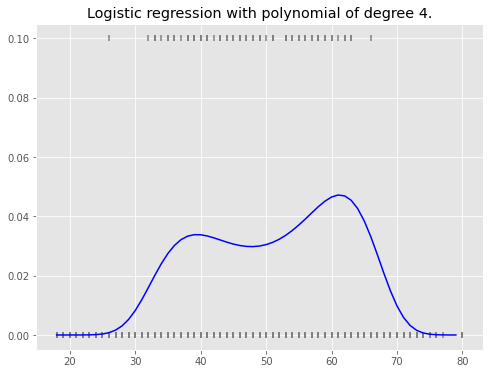

In [155]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(age_grid, y_pred_clf, color = 'b')
plt.scatter(wage.age, y_clf/10, c = "grey", marker = '|')
# ax.scatter(wage.age, y_clf/10, s = 10, c = "grey", marker = '|', alpha = 0.7)

plt.title("Logistic regression with polynomial of degree 4.")
plt.show()

#### Step function

In [156]:
wage_cut, bins = pd.cut(wage.age, 4, retbins = True)  # right default True
wage_cut.value_counts(sort = False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

자동 bin 지점(knots) 만들어줘서 참 편해. 역시 (auto or) compute가 최고야.

In [157]:
wage_step_dummies = pd.get_dummies(wage_cut, drop_first = True)
wage_step_dummies = pd.DataFrame(sm.add_constant(wage_step_dummies.values),
                                 columns = ["(Intercept)"] + list(wage_step_dummies.columns.values),
                                 index = wage_step_dummies.index)
wage_step_dummies.head(25)

,(Intercept),"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
231655,1.0,0.0,0.0,0.0
86582,1.0,0.0,0.0,0.0
161300,1.0,1.0,0.0,0.0
155159,1.0,1.0,0.0,0.0
11443,1.0,0.0,1.0,0.0
376662,1.0,0.0,1.0,0.0
450601,1.0,1.0,0.0,0.0
377954,1.0,0.0,0.0,0.0
228963,1.0,1.0,0.0,0.0
81404,1.0,0.0,1.0,0.0


In [158]:
logreg_step = sm.GLM(wage.wage, wage_step_dummies).fit()
print(logreg_step.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1634.1
Method:                          IRLS   Log-Likelihood:                -15353.
Date:                Wed, 10 Jun 2020   Deviance:                   4.8957e+06
Time:                        12:44:53   Pearson chi2:                 4.90e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
(Intercept)     94.1584      1.476     63.790   

### **Splines**
- from patsy import bs, cr

#### Cubic splines

In [0]:
transformed_3knots = dmatrix("bs(wage.age, knots = (25, 40, 60), degree = 3, include_intercept = False)",
                             {"wage.age": wage.age}, return_type = "dataframe")
# transformed_3knots = dmatrix(bs(wage.age, knots = (25, 40, 60), degree = 3, include_intercept = False), return_type = "dataframe")

In [160]:
spln_3knots = sm.GLM(wage.wage, transformed_3knots).fit()
pred_3knots = spln_3knots.predict(dmatrix("bs(age_grid, knots = (25, 40, 60), degree = 3, include_intercept = False)",
                                  {"age_grid": age_grid}, return_type = "dataframe"))
# pred_3knots = spln_3knots.predict(dmatrix(bs(age_grid, knots = (25, 40, 60), degree = 3, include_intercept = False), return_type = "dataframe"))
spln_3knots.params

Intercept                                                                 60.493714
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

x, x^2, x^3, h(x-25)^2, h(x-40)^2, h(x-60)^2<br />
h가 아니고 빅-감마처럼 생긴 기호였는데... 어쨌든 이래서 6개

In [0]:
transformed_deg6 = dmatrix("bs(wage.age, df = 6, include_intercept = False)", {"wage.age": wage.age},
                           return_type = "dataframe")
# transformed_deg6 = dmatrix(bs(wage.age, df = 6, include_intercept = False), return_type = "dataframe")

In [162]:
spln_deg6 = sm.GLM(wage.wage, transformed_deg6).fit()
pred_deg6 = spln_deg6.predict(dmatrix("bs(age_grid, df = 6, degree = 3, include_intercept = False)",
                                      {"age_grid": age_grid}, return_type = "dataframe"))
# pred_deg6 = spln_deg6.predict(dmatrix(bs(age_grid, df = 6, degree = 3, include_intercept = False), return_type = "dataframe"))
spln_deg6.params

Intercept                                         56.313841
bs(wage.age, df=6, include_intercept=False)[0]    27.824002
bs(wage.age, df=6, include_intercept=False)[1]    54.062546
bs(wage.age, df=6, include_intercept=False)[2]    65.828391
bs(wage.age, df=6, include_intercept=False)[3]    55.812734
bs(wage.age, df=6, include_intercept=False)[4]    72.131473
bs(wage.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

efficient degree of freedom?이 맞다면 자유도가 6이고, cubic 함수를 사용해서 knots 지점은 2개<br />
(df = 4 + K, if cubic)

x, x^2, x^3, I(x < 25), I(25 < x < 60), I(60 < x)로 6개?
- 숫자는 위에서 정한 것으로 그냥 쓴 것.
- I(25 < x)는 계수가 거의 0이고, intercept로 설명하므로 소거됨.
- 미분 불가능 점을 없애버린 위에 것(knots) 방법이 더 나은 거 아니었던가.

#### Natural Splines

dmatrix()
- cr(): natural regression splines
- cc(): cyclic cubic regression splines

In [0]:
transformed_deg4 = dmatrix("cr(wage.age, df = 4)", {"wage.age": wage.age}, return_type = "dataframe")
# transformed_deg4 = dmatrix(cr(wage.age, df = 4), return_type = "dataframe")

In [164]:
spln_deg4 = sm.GLM(wage.wage, transformed_deg4).fit()
pred_deg4 = spln_deg4.predict(dmatrix("cr(age_grid, df = 4)", {"age_grid": age_grid}, return_type = "dataframe"))
# pred_deg4 = spln_deg4.predict(dmatrix(cr(age_grid, df = 4), return_type = "dataframe"))
spln_deg4.params

Intercept                79.642095
cr(wage.age, df=4)[0]   -14.667784
cr(wage.age, df=4)[1]    36.811142
cr(wage.age, df=4)[2]    35.934874
cr(wage.age, df=4)[3]    21.563863
dtype: float64

이번 데이터에 대해선 df가 4니까 cubic이구나?

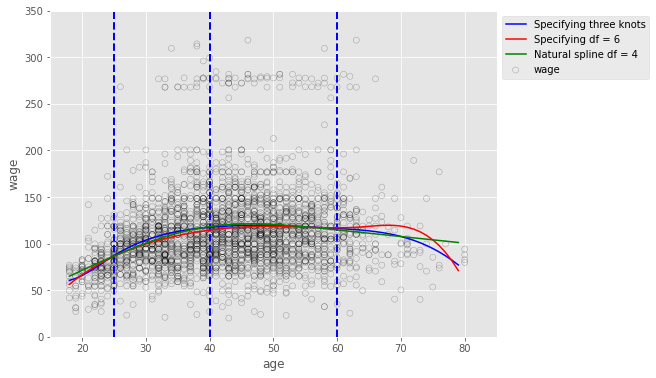

In [165]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(wage.age, wage.wage, facecolor = "None", edgecolors = 'k', alpha = 0.3, label = "wage")

# 범례 순서대로라 설명은 생략한다.
plt.plot(age_grid, pred_3knots, color = 'b', label = "Specifying three knots")
plt.plot(age_grid, pred_deg6, color = 'r', label = "Specifying df = 6")
plt.plot(age_grid, pred_deg4, color = 'g', label = "Natural spline df = 4")

# knots 구간 나누기
[plt.vlines(i, 0, 350, linestyles = "dashed", lw = 2, colors = 'b') for i in [25, 40, 60]]
# for i in [25, 40, 60]:
#   plt.vlines(i, 0, 350, linestyles = "dashed", lw = 2, colors = 'b')

plt.xlim(15, 85)
plt.ylim(0, 350)
plt.xlabel("age")
plt.ylabel("wage")
plt.legend(bbox_to_anchor = (1.0, 1.0)) # 범례 위치에 대한 설정
plt.show()